In [1]:
import xarray as xr
import rioxarray as rxr
import pyproj
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
ucrb_boundary = gpd.read_file('../multisite/polygons/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj)

hcdn_boundaries = gpd.read_file('./ucrb_hcdn_co_polygons_final.json')
hcdn_boundaries=hcdn_boundaries.to_crs(lcc_proj)


In [3]:
pet_ds = rxr.open_rasterio('../../data/pevap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rioxarray\_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [4]:
pet_ds = pet_ds.rio.write_crs(lcc_proj)
pet_ds_clipped = pet_ds.rio.clip(hcdn_boundaries.geometry)
pet_ds_masked=pet_ds_clipped.where(pet_ds_clipped['pevap']!=9.96921e+36)
# convert to mm equivalent
pet_ds_masked['pevap'] = pet_ds_masked['pevap']*30
pet_ds_masked['pevap'].attrs['units']='mm'

In [5]:
pet_ds_clipped_ucrb = pet_ds.rio.clip(ucrb_boundary.geometry)
pet_ds_masked_ucrb=pet_ds_clipped_ucrb.where(pet_ds_clipped_ucrb['pevap']!=9.96921e+36)
# convert to mm equivalent
pet_ds_masked_ucrb['pevap'] = pet_ds_masked_ucrb['pevap']*30
pet_ds_masked_ucrb['pevap'].attrs['units']='mm'

In [46]:
# PET for HCDN Boundaries
pet_ds_masked['WY'] = pet_ds_masked.time.dt.year.where(pet_ds_masked.time.dt.month<10,pet_ds_masked.time.dt.year+1)
pet_wy_ds_mean = pet_ds_masked.where(~pet_ds_masked['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim='x').mean(dim='y')
norm_pet_ds = ((pet_wy_ds_mean-pet_wy_ds_mean.mean(dim='WY'))/pet_wy_ds_mean.std(dim='WY'))['pevap']

# PET for UCRB as a whole
pet_ds_masked_ucrb['WY'] = pet_ds_masked_ucrb.time.dt.year.where(pet_ds_masked_ucrb.time.dt.month<10,pet_ds_masked_ucrb.time.dt.year+1)
pet_wy_ds_mean_ucrb = pet_ds_masked_ucrb.where(~pet_ds_masked_ucrb['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim='x').mean(dim='y')
norm_pet_ds_ucrb = ((pet_wy_ds_mean_ucrb-pet_wy_ds_mean_ucrb.mean(dim='WY'))/pet_wy_ds_mean_ucrb.std(dim='WY'))['pevap']

### Building PET anomalies across basin cells

In [113]:
df = pet_ds_masked.where(~pet_ds_masked['WY'].isin([1979,2023])).groupby('WY').sum().to_dataframe().reset_index()
et_gdf = gpd.GeoDataFrame(df[df['pevap']>0][['WY','pevap']], geometry=gpd.points_from_xy(x=df[df['pevap']>0].x,y=df[df['pevap']>0].y))
et_gdf['point'] = 0
cnt=0
for pt in et_gdf.geometry.unique():
    et_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
    cnt+=1

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_26852\892891114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_26852\892891114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_26852\892891114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [143]:
et_gdf_mean = et_gdf.dissolve(by='point',aggfunc='mean')['pevap']
et_gdf_std = et_gdf.dissolve(by='point',aggfunc='std')['pevap']

pt_anom = []
idx = np.arange(1980,2023,1)
for pt in et_gdf['point'].unique():
    norm_et_gdf = (et_gdf[et_gdf['point']==pt]['pevap'] - et_gdf_mean.loc[pt])/et_gdf_std.loc[pt]
    norm_et_gdf.index = idx
    norm_et_gdf.name=pt
    pt_anom.append(norm_et_gdf)
pet_point_df_hcdn = pd.DataFrame(pt_anom).T
# pet_point_df_hcdn.to_csv('./HCDN_PET_ANOMALY_POINTS.csv')

In [8]:
# East river 1km WRF ET
east_et_df = pd.read_csv('../../data/wrf_stand_anom_et_east.csv', sep='\t', header=None, index_col=0, names=['ET_rate'])

taylor_et_df = pd.read_csv('../../data/wrf_stand_anom_et_taylor.csv', sep='\t', header=None, index_col=0, names=['ET_rate'])


Text(0, 0.5, 'Evaporation/Potential ET Anomaly')

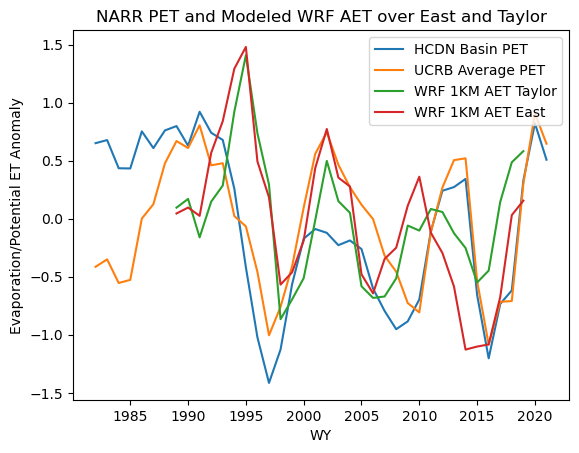

In [64]:
fig, ax = plt.subplots()
norm_pet_ds.rolling(WY=4, center=True).mean().plot(ax=ax, label='HCDN Basin PET')
norm_pet_ds_ucrb.rolling(WY=4, center=True).mean().plot(ax=ax, label='UCRB Average PET')

(-taylor_et_df['ET_rate']).rolling(4, center=True).mean().plot(ax=ax, label='WRF 1KM AET Taylor')
(-east_et_df['ET_rate']).rolling(4, center=True).mean().plot(ax=ax, label='WRF 1KM AET East')
ax.legend()
ax.set_title('NARR PET and Modeled WRF AET over East and Taylor')
ax.set_ylabel('Evaporation/Potential ET Anomaly')

### Same plot but for spring PET and ET

Text(0, 0.5, 'Evaporation/Potential ET Anomaly')

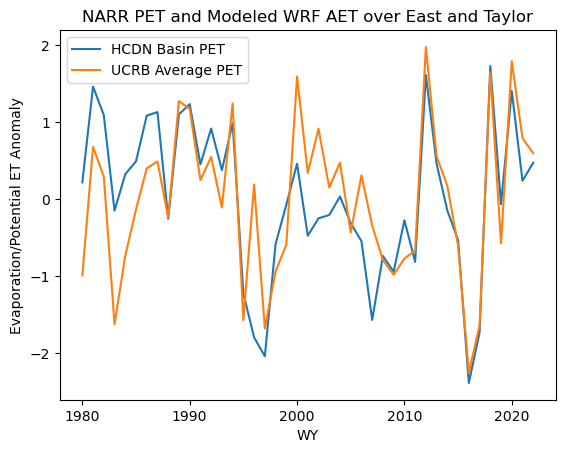

In [62]:
# PET for HCDN Boundaries
pet_ds_masked['WY'] = pet_ds_masked.time.dt.year.where(pet_ds_masked.time.dt.month<10,pet_ds_masked.time.dt.year+1)
pet_ds_masked = pet_ds_masked.where(pet_ds_masked.time.dt.month.isin([4,5,6]))
pet_wy_ds_mean = pet_ds_masked.where(~pet_ds_masked['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim='x').mean(dim='y')
norm_pet_ds = ((pet_wy_ds_mean-pet_wy_ds_mean.mean(dim='WY'))/pet_wy_ds_mean.std(dim='WY'))['pevap']

# PET for UCRB as a whole
pet_ds_masked_ucrb['WY'] = pet_ds_masked_ucrb.time.dt.year.where(pet_ds_masked_ucrb.time.dt.month<10,pet_ds_masked_ucrb.time.dt.year+1)
pet_ds_masked_ucrb = pet_ds_masked_ucrb.where(pet_ds_masked_ucrb.time.dt.month.isin([4,5,6]))
pet_wy_ds_mean_ucrb = pet_ds_masked_ucrb.where(~pet_ds_masked_ucrb['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim='x').mean(dim='y')
norm_pet_ds_ucrb = ((pet_wy_ds_mean_ucrb-pet_wy_ds_mean_ucrb.mean(dim='WY'))/pet_wy_ds_mean_ucrb.std(dim='WY'))['pevap']

fig, ax = plt.subplots()
norm_pet_ds.plot(ax=ax, label='HCDN Basin PET')
norm_pet_ds_ucrb.plot(ax=ax, label='UCRB Average PET')

# (-taylor_et_df['ET_rate']).rolling(4).mean().plot(ax=ax, label='WRF 1KM AET Taylor')
# (-east_et_df['ET_rate']).rolling(4).mean().plot(ax=ax, label='WRF 1KM AET East')
ax.legend()
ax.set_title('NARR PET and Modeled WRF AET over East and Taylor')
ax.set_ylabel('Evaporation/Potential ET Anomaly')

In [26]:
import seaborn as sns
from scipy.stats import pearsonr

0.8476386903354074
2.5395303944734474e-10
0.3376206169005661
0.050845383114614055
0.2380659713825078
0.17515787714813622
0.4398433888412453
0.009242179621341443
0.3005715297748617
0.08412139890199301
0.7480043719942859
3.6768484735211416e-07


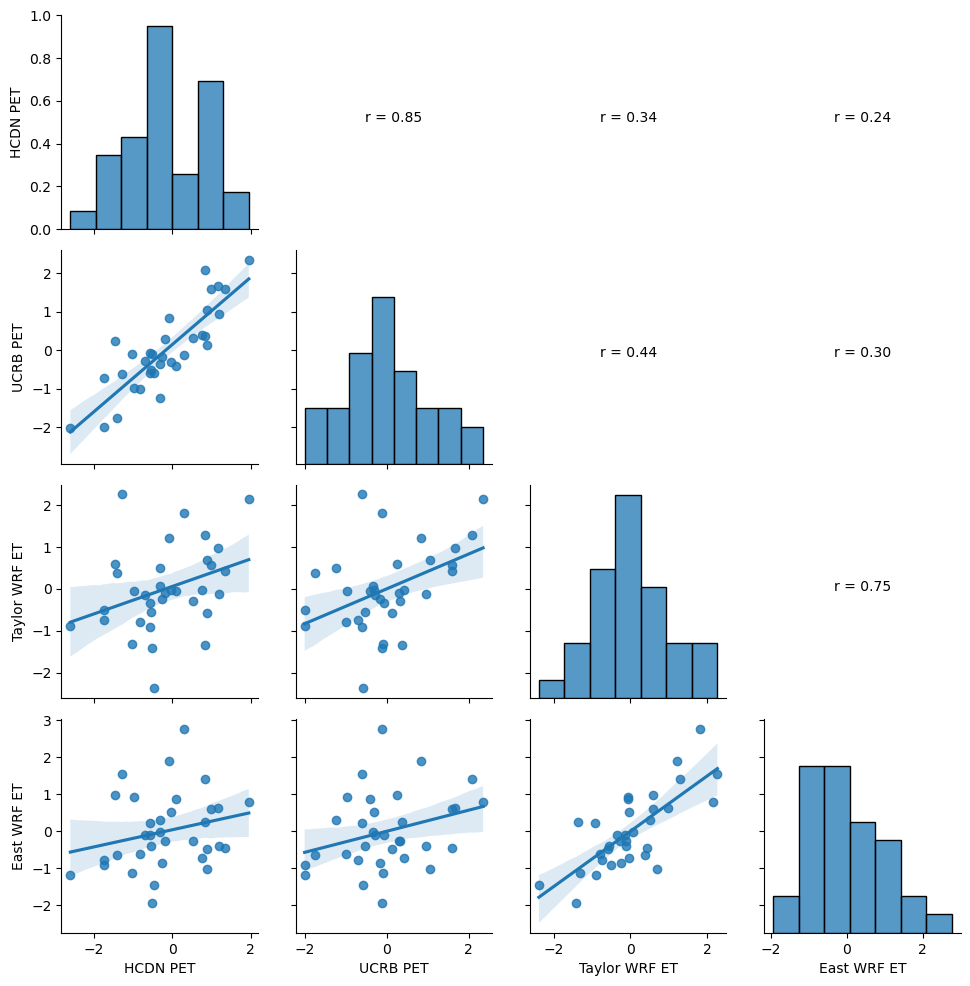

In [55]:
corr_df = pd.DataFrame([norm_pet_ds.to_dataframe().rename(columns={'pevap':'HCDN PET'})['HCDN PET'],
              norm_pet_ds_ucrb.to_dataframe().rename(columns={'pevap':'UCRB PET'})['UCRB PET'],
              -taylor_et_df.rename(columns={'ET_rate':'Taylor WRF ET'})['Taylor WRF ET'],
              -east_et_df.rename(columns={'ET_rate':'East WRF ET'})['East WRF ET']]).T.dropna()
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    print(r)
    print(p)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(corr_df)
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

In [31]:
corr_df

,HCDN PET,UCRB PET,Taylor WRF ET,East WRF ET
1987.0,0.899482,0.190548,-0.584713,-0.468004
1988.0,0.004516,-0.219448,-0.029817,0.521845
1989.0,1.015454,1.528949,0.578400,0.591371
1990.0,1.369614,1.536888,0.419215,-0.463823
1991.0,0.561673,0.364154,-0.284425,-0.264150
1992.0,0.867838,0.415652,-1.354505,0.236460
1993.0,0.347496,-0.052123,1.809809,2.763987
1994.0,1.195587,1.595168,0.973321,0.627009
1995.0,-1.203496,-0.502134,2.259949,1.544801
1996.0,-1.391956,0.283345,0.595292,0.987725
